# Importing libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
     batch_size=32, image_size=(256,256), shuffle=True,
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


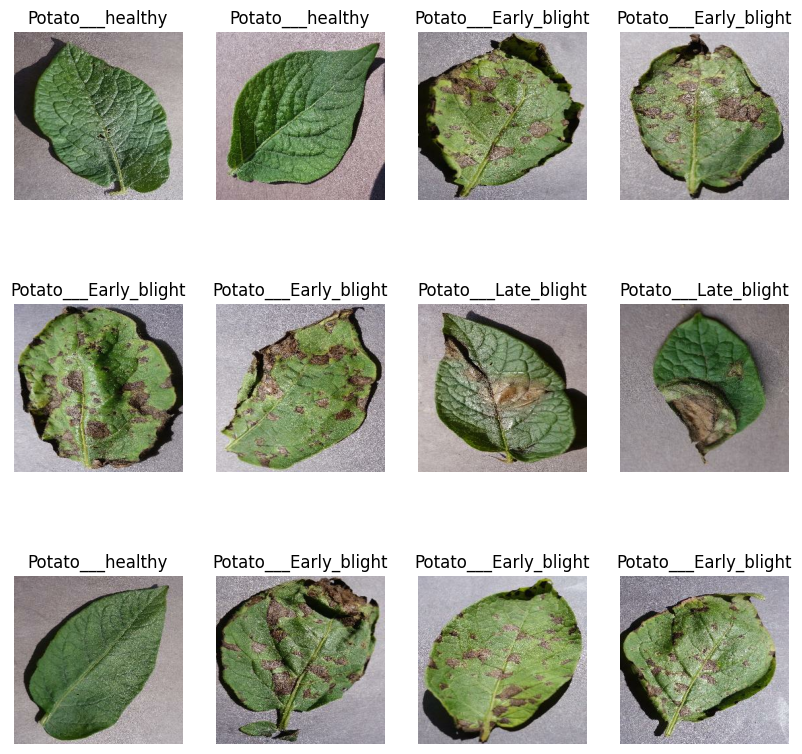

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [7]:
len(dataset)

68

In [8]:
train_size = int(0.8 * len(dataset))
train_size

54

In [9]:
train_ds = dataset.take(train_size)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(train_size)
len(test_ds)

14

In [11]:
val_size = int(0.1 * len(dataset))
val_size

6

In [12]:
val_ds = test_ds.take(val_size)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(val_size)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), input_shape = input_shape),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [24]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"]

)

In [25]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=1, batch_size=BATCH_SIZE)

Epoch 1/50
54/54 [==============================] - 51s 892ms/step - loss: 0.8460 - accuracy: 0.5359 - val_loss: 0.7848 - val_accuracy: 0.5833
Epoch 2/50
54/54 [==============================] - 45s 839ms/step - loss: 0.5079 - accuracy: 0.7778 - val_loss: 0.2715 - val_accuracy: 0.9010
Epoch 3/50
54/54 [==============================] - 45s 842ms/step - loss: 0.3033 - accuracy: 0.8727 - val_loss: 0.3592 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 48s 883ms/step - loss: 0.1841 - accuracy: 0.9277 - val_loss: 0.5016 - val_accuracy: 0.7552
Epoch 5/50
54/54 [==============================] - 46s 857ms/step - loss: 0.1421 - accuracy: 0.9433 - val_loss: 0.1587 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 48s 889ms/step - loss: 0.1327 - accuracy: 0.9491 - val_loss: 0.1964 - val_accuracy: 0.9271
Epoch 7/50
54/54 [==============================] - 48s 887ms/step - loss: 0.1383 - accuracy: 0.9497 - val_loss: 0.0928 - val_accuracy: 0.9792

In [111]:
model.evaluate(test_ds)

8/8 [==============================] - 2s 168ms/step - loss: 0.0836 - accuracy: 0.9648


[0.08360080420970917, 0.96484375]

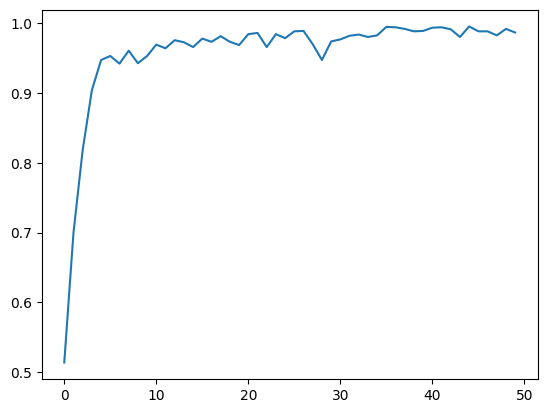

In [112]:
plt.plot(history.history["accuracy"])

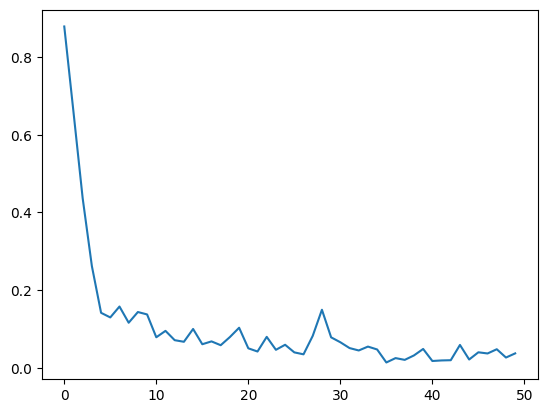

In [113]:
plt.plot(history.history["loss"])

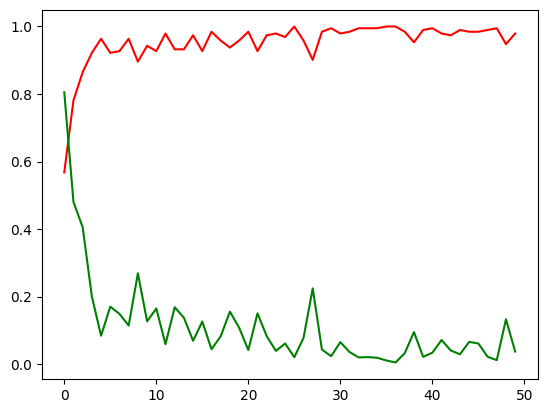

In [115]:
plt.plot(history.history["val_accuracy"], label="val_accuracy", c="red")
plt.plot(history.history["val_loss"], label="val_loss", c="green")


In [116]:
scores = model.evaluate(test_ds,)

8/8 [==============================] - 1s 163ms/step - loss: 0.0836 - accuracy: 0.9648


In [1]:
scores1 = model.evaluate(train_ds,)

NameError: name 'model' is not defined

In [120]:
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 96.48%


First image to predict:  (256, 256, 3)


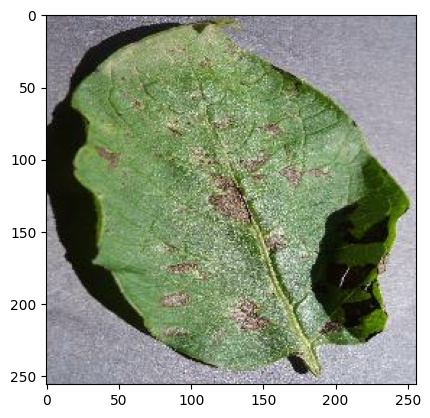

actuel label :  Potato___Early_blight
1/1 [==============================] - 0s 215ms/step
Predicted label:  Potato___Early_blight


In [127]:
for images_btch, labels_batch in test_ds.take(1):
    first_image = images_btch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()

    print("First image to predict: ", first_image.shape)
    plt.imshow(first_image)
    plt.show()
    print("actuel label : ", class_names[first_label])

    predictions = model.predict(images_btch)
    print("Predicted label: ", class_names[np.argmax(predictions[0])])

(256, 256, 3)


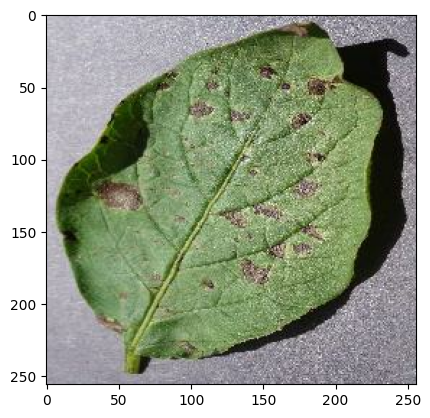

True:  Potato___Early_blight
(1, 256, 256, 3)
1/1 [==============================] - 0s 27ms/step
[[9.9602169e-01 3.9783888e-03 2.2339469e-08]]
Predicted:  Potato___Early_blight


In [128]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0]
    print(first_image.shape)
    plt.imshow(first_image)
    plt.show()
    print("True: ", class_names[first_label])
    first_image = np.expand_dims(first_image, axis=0)
    print(first_image.shape)
    predictions = model.predict(first_image)
    print(predictions)
    print("Predicted: ", class_names[np.argmax(predictions[0])])

In [129]:
def predict (model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence


In [131]:
'''
for images, labels in test_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()
    predictions = model.predict(images)
    for i in range(len(images)):
        predicted_class, confidence = predict(model, images[i])
        print("True: ", class_names[labels[i]])
        print("Predicted: ", predicted_class, "Confidence: ", confidence)
        print("______________________________")
'''


'\nfor images, labels in test_ds.take(1):\n    images = images.numpy()\n    labels = labels.numpy()\n    predictions = model.predict(images)\n    for i in range(len(images)):\n        predicted_class, confidence = predict(model, images[i])\n        print("True: ", class_names[labels[i]])\n        print("Predicted: ", predicted_class, "Confidence: ", confidence)\n        print("______________________________")\n'

1/1 [==============================] - 0s 26ms/step


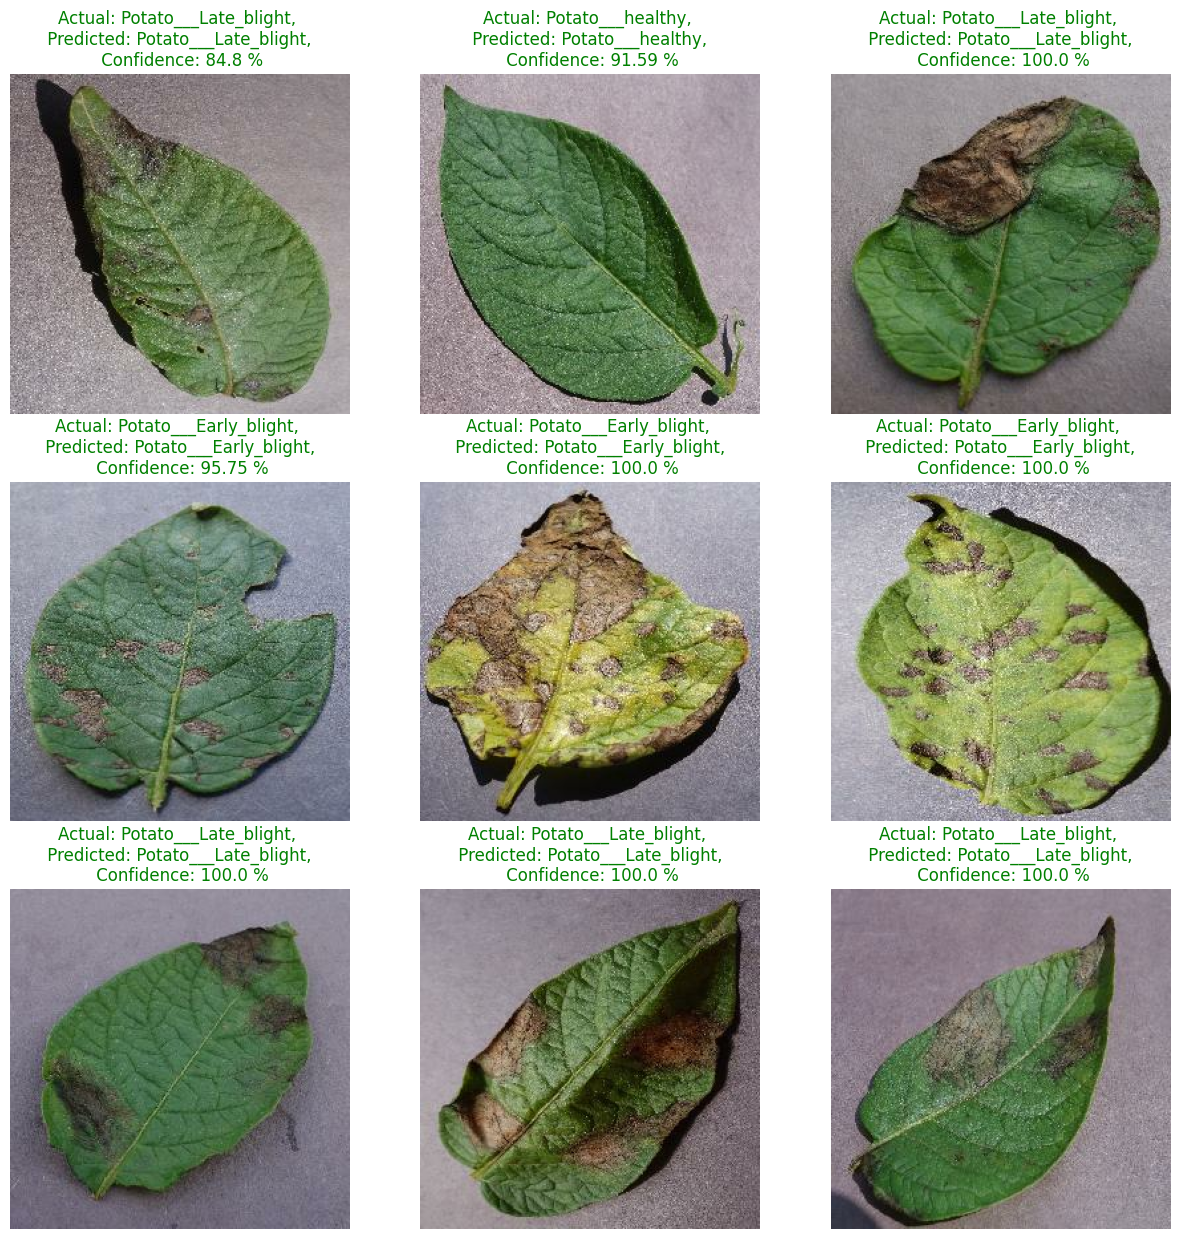

In [132]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence} %", color=("green" if predicted_class == actual_class else "red"))
        plt.axis("off")

In [133]:
model_version = 1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets


In [ ]:
import os
model_version = max([int(i) for i in os.listdir("./models")+ [0]]) + 1
model.save(f"./models/{model_version}")
for model_versionn in range (model_version) :
    model.save (f"./Models/ ([{model_versionn}] ) ")
    for i in os.listdir("./Models") + [0])+ 1
